In [1]:
import os, json
import pandas as pd

from data.paths import TabularDataPaths
from utils import print as print_f
from utils.preprocessing import get_split_list
from data.constants import XAMI_MIMIC_PATH, SPREADSHEET_FOLDER
from utils.init import reproducibility

In [2]:
seed = 0
reproducibility(0)

XAMI_MIMIC_PATH_str = "{XAMI_MIMIC_PATH}"

In [3]:
reflacx_meta_df = pd.read_csv(
    TabularDataPaths.SpreadSheet.get_sreadsheet(
        XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.REFLACX.metadata,
    )
)

In [4]:
len(reflacx_meta_df)

3052

# Remove instances without eye tracking data.

In [5]:
reflacx_meta_df = reflacx_meta_df[reflacx_meta_df['eye_tracking_data_discarded'] == False]

In [6]:
all_labels_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Quality issue",
    "Support devices",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


## inlcude the repetitive columns.
all_disease_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Emphysema",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Mass",
    "Nodule",
    "Other",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


In [7]:
def checkMissingValue(df):
    print(
        [
            (col, sum(df[col].isna()))
            for col in df.columns
            if df[col].isna().any()
        ]
    )

In [8]:
# Checking the columns that contian nan values.
print_f.print_title("Columns have NaN value in REFLACX metadata")
checkMissingValue(reflacx_meta_df)

====================Columns have NaN value in REFLACX metadata====================
[('Airway wall thickening', 2747), ('Emphysema', 2747), ('Fibrosis', 2747), ('Fracture', 2747), ('Mass', 2747), ('Nodule', 2747), ('Other', 2821), ('Pleural effusion', 2747), ('Pleural thickening', 2747), ('Quality issue', 2747), ('Wide mediastinum', 2747), ('Abnormal mediastinal contour', 285), ('Acute fracture', 285), ('Enlarged hilum', 285), ('Hiatal hernia', 285), ('High lung volume / emphysema', 285), ('Interstitial lung disease', 285), ('Lung nodule or mass', 285), ('Pleural abnormality', 285)]


In [9]:
# Filling nan for numerical cols.
reflacx_meta_df[all_disease_cols] = reflacx_meta_df[all_disease_cols].fillna(0)

# Folling nan for boolean cols.
reflacx_meta_df[["Quality issue", "Support devices"]] = reflacx_meta_df[
    ["Quality issue", "Support devices"]
].fillna(False)



In [10]:
print_f.print_title("Columns have missing value in REFLACX metadata.")

checkMissingValue(reflacx_meta_df)


====================Columns have missing value in REFLACX metadata.====================
[]


In [11]:
reflacx_meta_df["Lung nodule or mass"] = reflacx_meta_df[
    ["Lung nodule or mass", "Mass", "Nodule"]
].max(axis=1)
del reflacx_meta_df["Mass"]
del reflacx_meta_df["Nodule"]

reflacx_meta_df["High lung volume / emphysema"] = reflacx_meta_df[
    ["High lung volume / emphysema", "Emphysema"]
].max(axis=1)
del reflacx_meta_df["Emphysema"]


reflacx_meta_df["Pleural abnormality"] = reflacx_meta_df[
    ["Pleural abnormality", "Pleural thickening", "Pleural effusion"]
].max(axis=1)

del reflacx_meta_df["Pleural thickening"]
del reflacx_meta_df["Pleural effusion"]

In [12]:
cxr_meta_df = pd.read_csv(
    TabularDataPaths.SpreadSheet.get_sreadsheet(
        XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.cxr_meta
    )
)

In [13]:
merged_df = (
    reflacx_meta_df.merge(
        cxr_meta_df,
        "left",
        left_on="dicom_id",
        right_on="dicom_id",
        suffixes=("", "cxr"),
    )
)


In [14]:
## Calculate the age according to the time when the CXR taken.
merged_df["image_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\CXR-JPG\s"
    + merged_df["study_id"].astype(str)
    + "\\"
    + merged_df["dicom_id"].astype(str)
    + ".jpg"
)

merged_df["anomaly_location_ellipses_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\REFLACX\\"
    + merged_df["id"].astype(str)
    + "\\anomaly_location_ellipses.csv"
)

merged_df["fixations_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\REFLACX\\"
    + merged_df["id"].astype(str)
    + "\\fixations.csv"
)



In [15]:
# len(merged_df)

In [16]:
# from data.constants import XAMI_MIMIC_PATH

In [17]:
# fixation_exist = merged_df['fixations_path'].apply(lambda x: os.path.isfile(x.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH)))
# merged_df = merged_df[fixation_exist]

In [18]:
# len(merged_df)

In [19]:
needed_columns = [
    # ids
    "id",
    "dicom_id",
    "subject_id",
    "stay_id",
    "study_id",
    # image meta
    "image_path",
    "ViewPosition",
    "image_size_x",
    "image_size_y",
    "anomaly_location_ellipses_path",
    "fixations_path",
    # labels
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Groundglass opacity",
    "Other",
    "Pneumothorax",
    "Pulmonary edema",
    "Quality issue",
    "Support devices",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
    'Fracture' # don't have any positive case
]

merged_df = merged_df[needed_columns]


In [20]:
merged_df['split'] = get_split_list(len(merged_df), train_portion=0.7)

In [21]:
from collections import OrderedDict

count_map = dict((merged_df[all_labels_cols]>0).sum(axis=0))
OrderedDict({k: v for k, v in sorted(count_map.items(), key=lambda item: item[1])})

OrderedDict([('Fibrosis', 5),
             ('Quality issue', 9),
             ('Wide mediastinum', 10),
             ('Fracture', 12),
             ('Airway wall thickening', 21),
             ('Hiatal hernia', 24),
             ('Acute fracture', 33),
             ('Interstitial lung disease', 34),
             ('Enlarged hilum', 56),
             ('Abnormal mediastinal contour', 84),
             ('High lung volume / emphysema', 89),
             ('Pneumothorax', 105),
             ('Lung nodule or mass', 162),
             ('Groundglass opacity', 389),
             ('Pulmonary edema', 427),
             ('Enlarged cardiac silhouette', 710),
             ('Consolidation', 814),
             ('Atelectasis', 840),
             ('Pleural abnormality', 933),
             ('Support devices', 1305)])

# Exporting

In [22]:
merged_df = merged_df.reset_index()
merged_df.to_csv(os.path.join(SPREADSHEET_FOLDER, "reflacx_for_eyetracking.csv"))

In [23]:
exp_instance = merged_df.iloc[0]
exp_instance

index                                                                             0
id                                                                      P102R108387
dicom_id                               34cedb74-d0996b40-6d218312-a9174bea-d48dc033
subject_id                                                                 18111516
stay_id                                                                  32067002.0
study_id                                                                   55032240
image_path                        {XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...
ViewPosition                                                                     AP
image_size_x                                                                   2544
image_size_y                                                                   3056
anomaly_location_ellipses_path    {XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...
fixations_path                    {XAMI_MIMIC_PATH}\patient_18111516\REFLACX

# Heatmap example

In [24]:
from data.fixation import get_heatmap,  get_fixations_dict_from_fixation_df
import matplotlib.pyplot as plt

In [29]:
fixation_csv_path = exp_instance['fixations_path']
image_path = exp_instance['image_path'].replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH)
fixation_df = pd.read_csv(fixation_csv_path.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH))

In [46]:
heatmap = get_heatmap(get_fixations_dict_from_fixation_df(fixation_df), (exp_instance.image_size_x, exp_instance.image_size_y))

116026

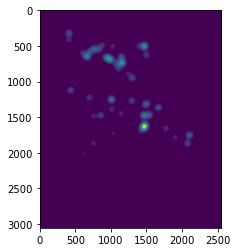

In [27]:
plt.imshow(heatmap)

In [28]:
image_path

'{XAMI_MIMIC_PATH}\\patient_18111516\\CXR-JPG\\s55032240\\34cedb74-d0996b40-6d218312-a9174bea-d48dc033.jpg'